In [30]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import numpy as np
from imodels import RuleListClassifier, RuleFit, SLIM, GreedyRuleList, SkopeRules
from sklearn.tree import DecisionTreeClassifier, plot_tree

import data
import validate
outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

train_idxs = data.pecarn_train_idxs
test_idxs1 = data.pecarn_test_idxs
test_idxs2 = data.psrc_train_idxs + data.psrc_test_idxs
df = df[df.cv_fold.isin(train_idxs)]
print(len(processed_feats), processed_feats)
X, y = df[processed_feats], df[outcome_def]
X_train, y_train = X[:len(y)//2], y[:len(y)//2]
X_test, y_test = X[len(y)//2:], y[len(y)//2:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


16 ['AbdDistention_or_AbdomenPain_yes', 'AbdTenderDegree_None', 'AbdTrauma_or_SeatBeltSign_yes', 'Age<2_yes', 'CostalTender_yes', 'DecrBreathSound_yes', 'GCSScore_Full_yes', 'Hypotension_yes', 'MOI_Bike collision/fall', 'MOI_Fall from an elevation', 'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision', 'MOI_Object struck abdomen', 'MOI_Pedestrian/bicyclist struck by moving vehicle', 'ThoracicTrauma_yes', 'VomitWretch_yes']


# fit simple models

**decision tree**

In [ ]:
# specify a decision tree with a maximum depth
dt = DecisionTreeClassifier(max_depth=4, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)

# calculat mse on the training data
preds = dt.predict(X_test)
preds_proba = dt.predict_proba(X_test)
# print(preds)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)

# print(f'test: {np.mean(np.square(preds-y_test)):0.2f}')
# print(sklearn.metrics.classification_report(y_test, preds))
plt.figure(dpi=300)
plot_tree(dt, feature_names=processed_feats, impurity=False, filled=True)
# plt.savefig('tree.pdf')
plt.show()

**bayesian rule lists**

training...


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RuleListClassifier Accuracy: 0.9838187702265372 Learned interpretable model:
 Trained RuleListClassifier for detecting IwI
IF DecrBreathSound_yes : 0.5_to_inf THEN probability of IwI: 14.9% (8.3%-23.1%)
ELSE IF AbdTrauma_or_SeatBeltSign_yes : -inf_to_0.5 AND InitSysBPRange : 85.5_to_inf THEN probability of IwI: 0.4% (0.2%-0.7%)
ELSE IF AbdDistention_yes : 0.5_to_inf THEN probability of IwI: 40.5% (25.5%-56.5%)
ELSE IF AbdTenderDegree_Severe : 0.5_to_inf THEN probability of IwI: 25.0% (13.9%-38.0%)
ELSE IF GCSScore_Full_yes : -inf_to_0.5 THEN probability of IwI: 11.5% (5.9%-18.5%)
ELSE probability of IwI: 1.2% (0.4%-2.3%)



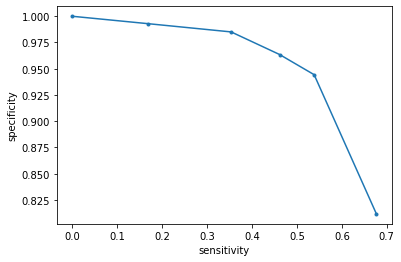

In [4]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training...')
model = RuleListClassifier(max_iter=10000, class1label="IwI", verbose=False)
model.fit(X_train, y_train, feature_labels=processed_feats)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, model.predict_proba(X_test)[:, 1])
print("RuleListClassifier Accuracy:", model.score(X_test, y_test), "Learned interpretable model:\n", model)

**rulefit**

In [ ]:
# fit a rulefit model
rf = RuleFit()
rf.fit(X_train, y_train, feature_names=processed_feats)

100%|██████████| 165/165 [00:01<00:00, 137.44it/s]


[0.96923077 0.96923077 0.95384615 0.95384615 0.95384615 0.93846154
 0.93846154 0.93846154 0.90769231 0.90769231 0.90769231] [0.38183198 0.43598178 0.45394737 0.47343117 0.49671053 0.49797571
 0.50885628 0.51771255 0.52327935 0.52530364 0.52606275]


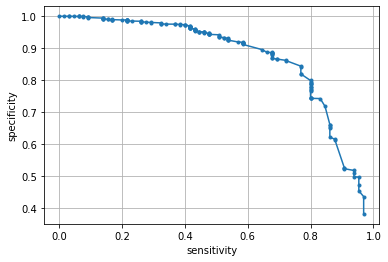

In [20]:
preds = rf.predict(X_test)
# preds_proba = rf.predict_proba(X_test)
# print(preds)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds, plot=True)
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
# print(sklearn.metrics.classification_report(y_test, preds))

In [ ]:
rules = rf.get_rules()

rules = rules[rules.coef != 0].sort_values("support", ascending=False)

print(rules)

**slim**

In [17]:
# specify a decision tree with a maximum depth
fewest_feats = data.fewest_feats
X_train_small = X_train[fewest_feats]
m = SLIM()
n = 100

# optionally upweight positive samples
CLASS_WEIGHT = 100
sample_weight = np.ones((n))
sample_weight[y_train[:n] == 1] *= CLASS_WEIGHT
sample_weight /= sample_weight.max()

# fit
m.fit(X_train_small[:n], y_train[:n] * 100, lambda_reg=10,
      sample_weight=sample_weight)

# calculate mse on the training data
X_test_small = X_test[fewest_feats]
preds = m.predict(X_test_small)
preds_proba = [1 / (1 + np.exp(-y)) for y in preds]
# preds_proba = m.predict_proba(X_test)
print(m.model.coef_.astype(int), m.model.intercept_)

shapes (100,) (100,)
[-55  -3   0  14  -4   0 -81 -15   0   0  -5   0] 0


 94%|█████████▍| 140/149 [00:01<00:00, 133.01it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 149/149 [00:01<00:00, 134.66it/s]


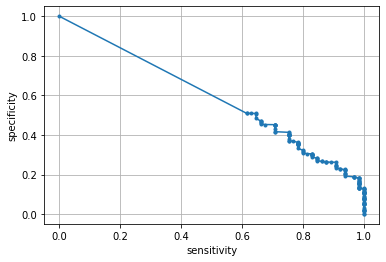

In [18]:
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba)

**skope rules**

100%|██████████| 5/5 [00:00<00:00, 149.30it/s]

Rules for iai
('AbdTenderDegree_None <= 0.5 and VomitWretch_yes > 0.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5', (0.3374102177022088, 0.1972376642964878, 5))
('ThoracicTrauma_yes > 0.5 and GCSScore_Full_yes <= 0.5 and Hypotension_yes > 0.5', (0.6666666666666666, 0.11538461538461539, 1))
('MOI_Motor vehicle collision > 0.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5 and Hypotension_yes > 0.5', (0.6696428571428572, 0.10536823425022182, 2))
('MOI_Motor vehicle collision > 0.5 and ThoracicTrauma_yes > 0.5 and DecrBreathSound_yes > 0.5', (0.45454545454545453, 0.10204081632653061, 1))


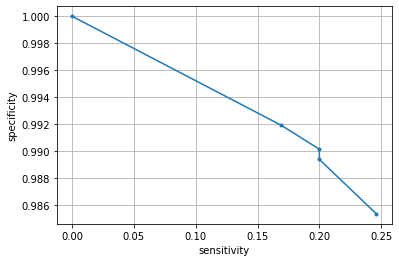

In [5]:
# feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
clf = SkopeRules(max_depth_duplication=3,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=processed_feats)
clf.fit(X_train, y_train)
# print the rules
rules = clf.rules_
print("Rules for iai")
for rule in rules:
    print(rule)

# evaluate
y_score = clf.score_top_rules(X_test) # Get a risk score for each test example

sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, y_score)
plt.show()

**greedy rule list**

In [43]:
class_weight = {0: 1, 1: 500}
d = GreedyRuleList(max_depth=7, class_weight=class_weight, criterion='gini')
d.fit(X_train, y_train, verbose=True)

mean 1.619


[{'col': 'VomitWretch_yes',
  'index_col': 15,
  'cutoff': 0,
  'val': 0.016185258964143426,
  'flip': False,
  'val_right': 0.016185258964143426,
  'num_pts': 4016,
  'num_pts_right': 4016}]

In [42]:
d.print_list()

	                                    => 1.62% risk (4016 pts)
                     if DecrBreathSound_yes ===> 14.1% risk (85 pts)
	                                    => 1.35% risk (3931 pts)
                         if Hypotension_yes ===> 14.3% risk (56 pts)
	                                    => 1.16% risk (3875 pts)
           if AbdTrauma_or_SeatBeltSign_yes ===> 5.2% risk (599 pts)
	                                    => 0.43% risk (3276 pts)
                      if ~GCSScore_Full_yes ===> 1.4% risk (424 pts)
	                                    => 0.28% risk (2852 pts)
                 if MOI_Bike collision/fall ===> 1.3% risk (153 pts)
	                                    => 0.22% risk (2699 pts)
                   if ~AbdTenderDegree_None ===> 0.5% risk (752 pts)
	                                    => 0.1% risk (1947 pts)
    if MOI_Motorcycle/ATV/Scooter collision ===> 0.9% risk (112 pts)



100%|██████████| 8/8 [00:00<00:00, 147.28it/s]


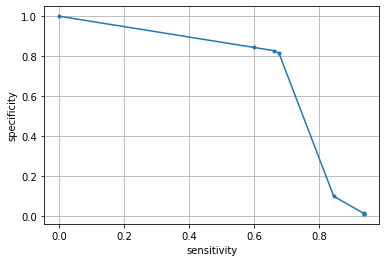

In [17]:
preds_proba = d.predict_proba(X_train)[:, 1]
sens1, spec1, threshes = validate.sensitivity_specificity_curve(y_train, preds_proba, plot=False)
preds_proba = d.predict_proba(X_test)[:, 1]
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba, plot=True)
plt.show()

  3%|▎         | 5/196 [00:00<00:04, 47.53it/s]

[0 0 0 ... 0 0 0]


100%|██████████| 196/196 [00:03<00:00, 65.07it/s]


test: 0.02


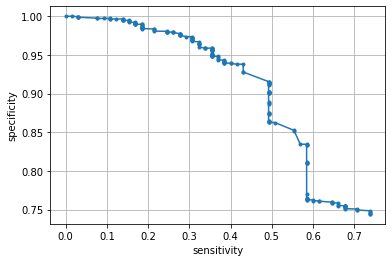

In [16]:
from imodels import IRFClassifier
# specify a decision tree with a maximum depth
irf = IRFClassifier()
irf.fit(X_train, y_train)

# calculat mse on the training data
preds = irf.predict(X_test)
preds_proba = irf.predict_proba(X_test)
print(preds)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1], plot=True)

# irf.model.all_rf_weights # look at model weights

print(f'test: {np.mean(np.square(preds-y_test)):0.2f}')
# print(sklearn.metrics.classification_report(y_test, preds))

In [29]:
imps = irf.model.feature_importances_.round(3) * 100
args = np.argsort(imps)
imps = imps[args]
feats = np.array(processed_feats)[args]
for imp, feat in zip(imps, feats):
    print(feat, imp)

MOI_Motorcycle/ATV/Scooter collision 2.6
MOI_Bike collision/fall 3.3000000000000003
MOI_Pedestrian/bicyclist struck by moving vehicle 3.6999999999999997
AbdDistention_or_AbdomenPain_yes 3.8
MOI_Fall from an elevation 4.0
Age<2_yes 4.2
MOI_Object struck abdomen 4.3999999999999995
MOI_Motor vehicle collision 6.7
CostalTender_yes 7.000000000000001
Hypotension_yes 7.3999999999999995
DecrBreathSound_yes 7.6
AbdTenderDegree_None 8.0
AbdTrauma_or_SeatBeltSign_yes 8.6
GCSScore_Full_yes 8.799999999999999
VomitWretch_yes 9.1
ThoracicTrauma_yes 10.8
